#### Imports

In [1]:
import numpy as np 
import pandas as pd 

import allensdk
import allensdk.brain_observatory.behavior.behavior_project_cache as bpc

import matplotlib.pyplot as plt 
import matplotlib
import seaborn as sns

import sklearn
from sklearn.decomposition import PCA

from tqdm import tqdm

import torch
from torch import nn
from torchvision.transforms import Resize

sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})
matplotlib.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['figure.dpi'] = 150

/home/abalwani6/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#### Load data

In [3]:
cache_dir = r"Data"
bc = bpc.VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=cache_dir)

/home/abalwani6/.local/lib/python3.10/site-packages/allensdk/brain_observatory/behavior/behavior_project_cache/behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(


In [4]:
behavior_session_table = bc.get_behavior_session_table()  
ophys_session_table = bc.get_ophys_session_table()   
experiment_table = bc.get_ophys_experiment_table()

print(f"Number of behavior sessions = {len(behavior_session_table)}")
print(f"Number of ophys sessions = {len(ophys_session_table)}")
print(f"Number of ophys experiments = {len(experiment_table)}")

Number of behavior sessions = 4782
Number of ophys sessions = 703
Number of ophys experiments = 1936


In [5]:
# PC, ViP, SST lines 
pc_line_str = 'Slc17a7-IRES2-Cre' 
sst_line_str = 'Sst-IRES-Cre'
vip_line_str = 'Vip-IRES-Cre' 

In [6]:
# filtering by cell type 
pc_exp_table = experiment_table[(experiment_table.cre_line==pc_line_str)]
vip_exp_table = experiment_table[(experiment_table.cre_line==vip_line_str)]
sst_exp_table = experiment_table[(experiment_table.cre_line==sst_line_str)]

# numbers 
print(f"Number of experiments with PC neurons = {len(pc_exp_table)}")
print(f"Number of experiments with VIP neurons = {len(vip_exp_table)}")
print(f"Number of experiments with SST neurons = {len(sst_exp_table)}")

Number of experiments with PC neurons = 871
Number of experiments with VIP neurons = 663
Number of experiments with SST neurons = 402


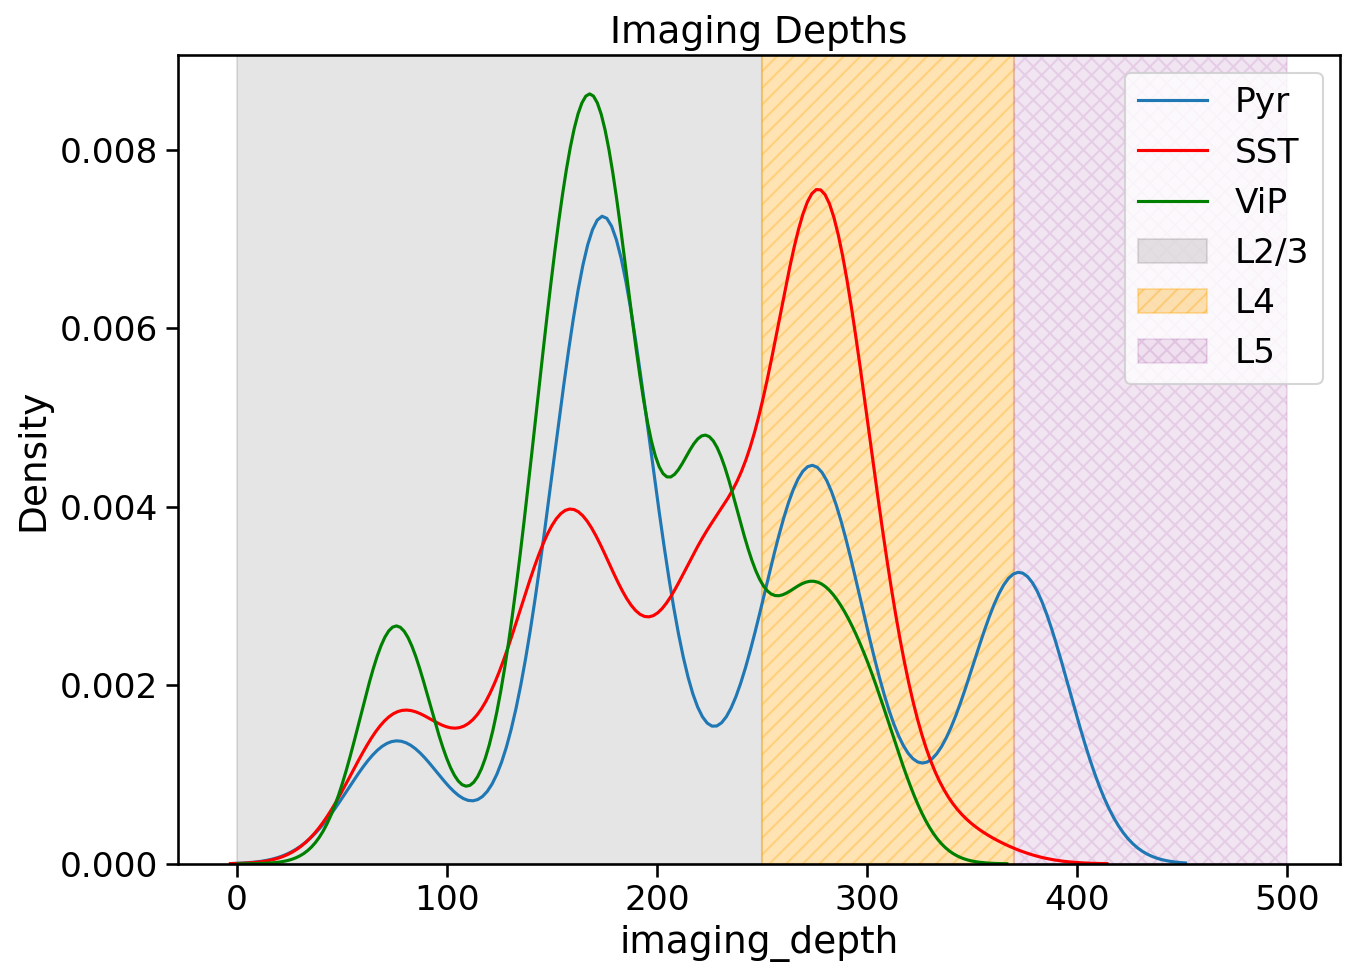

In [7]:
sns.kdeplot(data=pc_exp_table, x="imaging_depth",label='Pyr')
sns.kdeplot(data=sst_exp_table, x="imaging_depth",color='r',label='SST')
sns.kdeplot(data=vip_exp_table, x="imaging_depth",color='g',label='ViP')

## Add shaded panels
## previous numbers
# L23_start, L23_end = 125, 185  # define the range for L23
# L4_start, L4_end = 160, 210  # define the range for L4
# L5_start, L5_end = 220, 300  # define the range for L5

## new numbers
L23_start, L23_end = 0, 250 # define the range for L23
L4_start, L4_end = 250, 370  # define the range for L4
L5_start, L5_end = 370, 500  # define the range for L5


plt.axvspan(L23_start, L23_end, color='k',hatch='', alpha=0.1, label='L2/3')
plt.axvspan(L4_start, L4_end, color='orange',hatch='///', alpha=0.3, label='L4')
plt.axvspan(L5_start, L5_end, color='purple',hatch='xxx', alpha=0.1, label='L5')

plt.title('Imaging Depths')
plt.legend()

#### Filter dataset

In [8]:
## Filter by project type
filter_pyr = pc_exp_table[pc_exp_table['project_code'] == 'VisualBehaviorMultiscope']
filter_sst = sst_exp_table[sst_exp_table['project_code'] == 'VisualBehaviorMultiscope']
filter_vip = vip_exp_table[vip_exp_table['project_code'] == 'VisualBehaviorMultiscope']

## Keep only active sessions
filter_pyr = filter_pyr[filter_pyr['passive'] == False]
filter_sst = filter_sst[filter_sst['passive'] == False]
filter_vip = filter_vip[filter_vip['passive'] == False]

## Filter to keep only FAMILIAR sessions
filter_pyr = filter_pyr[filter_pyr['experience_level'] == 'Familiar']
filter_sst = filter_sst[filter_sst['experience_level'] == 'Familiar']
filter_vip = filter_vip[filter_vip['experience_level'] == 'Familiar']

In [9]:
# numbers 
print(f"Number of experiments with PYR neurons = {len(filter_pyr)}")
print(f"Number of experiments with SST neurons = {len(filter_sst)}")
print(f"Number of experiments with VIP neurons = {len(filter_vip)}")

Number of experiments with PYR neurons = 124
Number of experiments with SST neurons = 77
Number of experiments with VIP neurons = 117


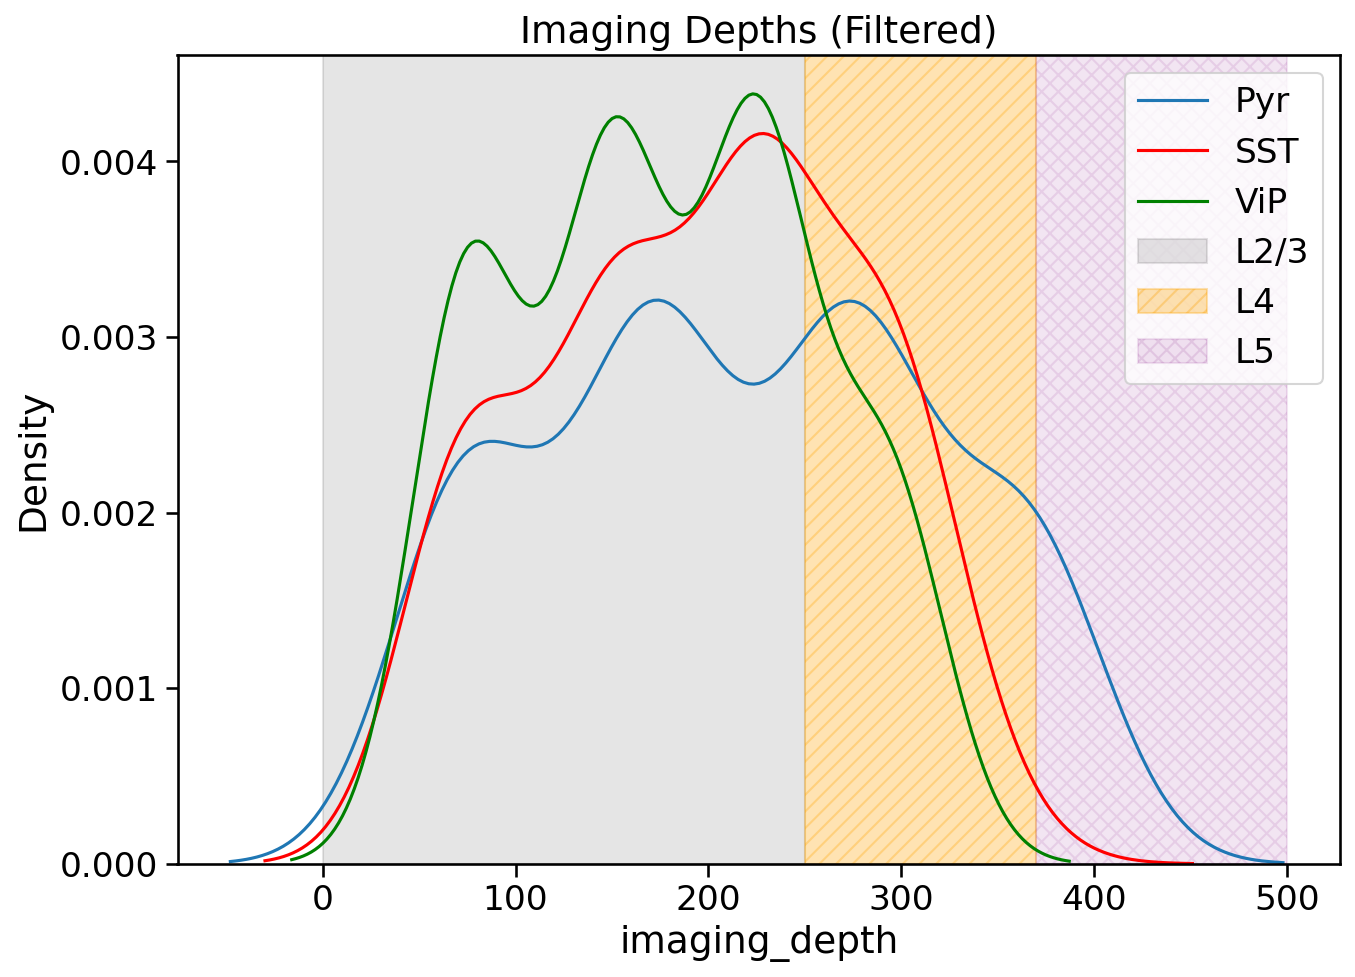

In [10]:
sns.kdeplot(data=filter_pyr, x="imaging_depth",label='Pyr')
sns.kdeplot(data=filter_sst, x="imaging_depth",color='r',label='SST')
sns.kdeplot(data=filter_vip, x="imaging_depth",color='g',label='ViP')

## Add shaded panels
# L23_start, L23_end = 125, 250 # define the range for L23
# L4_start, L4_end = 250, 370  # define the range for L4
# L5_start, L5_end = 310, 500  # define the range for L5

## new numbers
L23_start, L23_end = 0, 250 # define the range for L23
L4_start, L4_end = 250, 370  # define the range for L4
L5_start, L5_end = 370, 500  # define the range for L5

plt.axvspan(L23_start, L23_end, color='k',hatch='', alpha=0.1, label='L2/3')
plt.axvspan(L4_start, L4_end, color='orange',hatch='///', alpha=0.3, label='L4')
plt.axvspan(L5_start, L5_end, color='purple',hatch='xxx', alpha=0.1, label='L5')

plt.title('Imaging Depths (Filtered)')
plt.legend()

#### Split into individual cell types

In [11]:
pyr_visp = filter_pyr[filter_pyr.targeted_structure=='VISp']
sst_visp = filter_sst[filter_sst.targeted_structure=='VISp']
vip_visp = filter_vip[filter_vip.targeted_structure=='VISp']

pyr_visl = filter_pyr[filter_pyr.targeted_structure=='VISl']
sst_visl = filter_sst[filter_sst.targeted_structure=='VISl']
vip_visl = filter_vip[filter_vip.targeted_structure=='VISl']

#### Depthwise splitting (individual cell types)

In [12]:
depths_pyr_visp = pyr_visp.imaging_depth
depths_sst_visp = sst_visp.imaging_depth
depths_vip_visp = vip_visp.imaging_depth

depths_pyr_visl = pyr_visl.imaging_depth
depths_sst_visl = sst_visl.imaging_depth
depths_vip_visl = vip_visl.imaging_depth

In [13]:
print('Pyr (VISp):',np.unique(depths_pyr_visp))
print('SST (VISp):',np.unique(depths_sst_visp))
print('ViP (VISp):',np.unique(depths_vip_visp))

Pyr (VISp): [ 67  69  73  75  77  79 150 161 165 169 171 175 181 183 225 229 263 267
 269 270 273 275 298 300 340 359 361 365 371 373 375 381 383]
SST (VISp): [ 75  81 144 145 150 154 175 221 225 230 275 300 320 321 350]
ViP (VISp): [ 71  73  75  77  79  81 150 152 154 156 158 217 219 221 225 270 278 298
 300]


In [14]:
pyr_visp_L23_ophys_ids = pyr_visp[(pyr_visp['imaging_depth'] >= L23_start) & (pyr_visp['imaging_depth'] <= L23_end)]['ophys_session_id']
sst_visp_L23_ophys_ids = sst_visp[(sst_visp['imaging_depth'] >= L23_start) & (sst_visp['imaging_depth'] <= L23_end)]['ophys_session_id']
vip_visp_L23_ophys_ids = vip_visp[(vip_visp['imaging_depth'] >= L23_start) & (vip_visp['imaging_depth'] <= L23_end)]['ophys_session_id']

pyr_visp_L4_ophys_ids = pyr_visp[(pyr_visp['imaging_depth'] >= L4_start) & (pyr_visp['imaging_depth'] <= L4_end)]['ophys_session_id']
sst_visp_L4_ophys_ids = sst_visp[(sst_visp['imaging_depth'] >= L4_start) & (sst_visp['imaging_depth'] <= L4_end)]['ophys_session_id']
vip_visp_L4_ophys_ids = vip_visp[(vip_visp['imaging_depth'] >= L4_start) & (vip_visp['imaging_depth'] <= L4_end)]['ophys_session_id']

pyr_visp_L5_ophys_ids = pyr_visp[(pyr_visp['imaging_depth'] >= L5_start) & (pyr_visp['imaging_depth'] <= L5_end)]['ophys_session_id']
sst_visp_L5_ophys_ids = sst_visp[(sst_visp['imaging_depth'] >= 295) & (sst_visp['imaging_depth'] <= L5_end)]['ophys_session_id']
vip_visp_L5_ophys_ids = vip_visp[(vip_visp['imaging_depth'] >= 295) & (vip_visp['imaging_depth'] <= L5_end)]['ophys_session_id']

In [15]:
print(len(pyr_visp_L23_ophys_ids))
print(len(sst_visp_L23_ophys_ids))
print(len(vip_visp_L23_ophys_ids))

print(len(pyr_visp_L4_ophys_ids))
print(len(sst_visp_L4_ophys_ids))
print(len(vip_visp_L4_ophys_ids))

print(len(pyr_visp_L5_ophys_ids))
print(len(sst_visp_L5_ophys_ids))
print(len(vip_visp_L5_ophys_ids))

35
37
48
23
9
4
8
7
2


In [16]:
print('Pyr (VISl):',np.unique(depths_pyr_visl))
print('SST (VISl):',np.unique(depths_sst_visl))
print('ViP (VISl):',np.unique(depths_vip_visl))

Pyr (VISl): [ 71  75  77  79  85 150 167 169 171 175 181 221 225 259 263 270 271 275
 277 283 300 345 355 359 363 365 373 375 379]
SST (VISl): [ 71  75 150 175 213 225 228 230 235 275 283 284 285 290 300]
ViP (VISl): [ 71  75  79  93 144 148 150 162 174 211 219 225 274 276 282 286 292 294
 300]


In [17]:
pyr_visl_L23_ophys_ids = pyr_visl[(pyr_visl['imaging_depth'] >= L23_start) & (pyr_visl['imaging_depth'] <= L23_end)]['ophys_session_id']
sst_visl_L23_ophys_ids = sst_visl[(sst_visl['imaging_depth'] >= L23_start) & (sst_visl['imaging_depth'] <= L23_end)]['ophys_session_id']
vip_visl_L23_ophys_ids = vip_visl[(vip_visl['imaging_depth'] >= L23_start) & (vip_visl['imaging_depth'] <= L23_end)]['ophys_session_id']

pyr_visl_L4_ophys_ids = pyr_visl[(pyr_visl['imaging_depth'] >= L4_start) & (pyr_visl['imaging_depth'] <= L4_end)]['ophys_session_id']
sst_visl_L4_ophys_ids = sst_visl[(sst_visl['imaging_depth'] >= L4_start) & (sst_visl['imaging_depth'] <= L4_end)]['ophys_session_id']
vip_visl_L4_ophys_ids = vip_visl[(vip_visl['imaging_depth'] >= L4_start) & (vip_visl['imaging_depth'] <= L4_end)]['ophys_session_id']

pyr_visl_L5_ophys_ids = pyr_visl[(pyr_visl['imaging_depth'] >= L5_start) & (pyr_visl['imaging_depth'] <= L5_end)]['ophys_session_id']
sst_visl_L5_ophys_ids = sst_visl[(sst_visl['imaging_depth'] >= 295) & (sst_visl['imaging_depth'] <= L5_end)]['ophys_session_id']
vip_visl_L5_ophys_ids = vip_visl[(vip_visl['imaging_depth'] >= 295) & (vip_visl['imaging_depth'] <= L5_end)]['ophys_session_id']

In [18]:
print(len(pyr_visl_L23_ophys_ids))
print(len(sst_visl_L23_ophys_ids))
print(len(vip_visl_L23_ophys_ids))

print(len(pyr_visl_L4_ophys_ids))
print(len(sst_visl_L4_ophys_ids))
print(len(vip_visl_L4_ophys_ids))

print(len(pyr_visl_L5_ophys_ids))
print(len(sst_visl_L5_ophys_ids))
print(len(vip_visl_L5_ophys_ids))

32
20
49
23
11
16
3
5
8


#### Download experiments and produce average response

In [19]:
def generate_trial_avg_response_faniliar_no_change(ophys_ids, default_length=16):
    
    dff_avg_stacked_full_flag = False
    for ii in range(len(ophys_ids)):
        try:
            experiment = bc.get_behavior_ophys_experiment(ophys_ids.index[ii])
        except OSError:
            print('Skipping an experiment')
            continue
            
        timestamps = experiment.ophys_timestamps
        stim_table = experiment.stimulus_presentations
        trial_table = experiment.trials.merge(experiment._trials._trials.fillna(method='ffill'), left_index=True, right_index=True)
        trial_table = trial_table[trial_table.is_change_x==True] ## only samples with eventual changes in image ID
        
        dff_array = np.vstack(experiment.dff_traces['dff'].values)

        # print(ii)
        # print(len(trial_table))
        # print('-----------------')
        
        initial_array_flag = False
        for jj in range(len(trial_table)):
            sample_trial = trial_table.iloc[jj]
            
            start_time = sample_trial['start_time_x']
            stop_time = sample_trial['stop_time_x']

            # Filter stimulus presentations based on start and stop times
            filtered_stimuli = stim_table[(stim_table['start_time'] >= start_time) & (stim_table['start_time'] <= stop_time)]
        
            # Extract image names 
            images = [image_name for image_name in filtered_stimuli['image_name']]

            #### CHECK FOR DELTA DEFINITION!!!
            if len(np.where(images == 'omitted')[0]) == 0:
    
                sub_start = start_time
                sub_end = sub_start + 2*(0.25 + 0.5)
                
                trial_mask = (timestamps >= start_time) & (timestamps <= stop_time)
                
                # Filter dF/F traces based on the trial mask
                dff_trial = dff_array[:, trial_mask]

                delta = np.round((stop_time - start_time)/np.sum(trial_mask),3)
                
                sub_start_frame = int((sub_start - start_time)/delta)
                sub_end_frame = int((sub_end - start_time)/delta)

                if (sub_end_frame-sub_start_frame)!=default_length:
                   dff_avg = np.mean(dff_trial,0)[sub_start_frame:sub_start_frame+default_length]
                else:
                    dff_avg = np.mean(dff_trial,0)[sub_start_frame:sub_end_frame]

                if initial_array_flag == False:
                    dff_avg_stacked = dff_avg
                    initial_array_flag = True
                else:
                    dff_avg_stacked = np.vstack((dff_avg_stacked, dff_avg))
                
        if dff_avg_stacked_full_flag == False:
            dff_avg_stacked_full = dff_avg_stacked
            dff_avg_stacked_full_flag = True
        else:
            dff_avg_stacked_full = np.vstack((dff_avg_stacked_full,dff_avg_stacked))
                
    return dff_avg_stacked_full

In [20]:
dff_pyr_visp_L23 = generate_trial_avg_response_faniliar_no_change(pyr_visp_L23_ophys_ids)
np.save('dff_pyr_visp_L23_familiar_no_change.npy',dff_pyr_visp_L23)
print('Pyr - L23')
dff_pyr_visp_L4 = generate_trial_avg_response_faniliar_no_change(pyr_visp_L4_ophys_ids)
np.save('dff_pyr_visp_L4_familiar_no_change.npy',dff_pyr_visp_L4)
print('Pyr - L4')
dff_pyr_visp_L5 = generate_trial_avg_response_faniliar_no_change(pyr_visp_L5_ophys_ids)
np.save('dff_pyr_visp_L5_familiar_no_change.npy',dff_pyr_visp_L5)
print('Pyr - L5')

dff_sst_visp_L23 = generate_trial_avg_response_faniliar_no_change(sst_visp_L23_ophys_ids)
np.save('dff_sst_visp_L23_familiar_no_change.npy',dff_sst_visp_L23)
print('SST - L23')
dff_sst_visp_L4 = generate_trial_avg_response_faniliar_no_change(sst_visp_L4_ophys_ids)
np.save('dff_sst_visp_L4_familiar_no_change.npy',dff_sst_visp_L4)
print('SST - L4')
dff_sst_visp_L5 = generate_trial_avg_response_faniliar_no_change(sst_visp_L5_ophys_ids)
np.save('dff_sst_visp_L5_familiar_no_change.npy',dff_sst_visp_L5)
print('SST - L5')

dff_vip_visp_L23 = generate_trial_avg_response_faniliar_no_change(vip_visp_L23_ophys_ids)
np.save('dff_vip_visp_L23_familiar_no_change.npy',dff_vip_visp_L23)
print('VIP - L23')
dff_vip_visp_L4 = generate_trial_avg_response_faniliar_no_change(vip_visp_L4_ophys_ids)
np.save('dff_vip_visp_L4_familiar_no_change.npy',dff_vip_visp_L4)
print('VIP - L4')
dff_vip_visp_L5 = generate_trial_avg_response_faniliar_no_change(vip_visp_L5_ophys_ids)
np.save('dff_vip_visp_L5_familiar_no_change.npy',dff_vip_visp_L5)
print('VIP - L5')

/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Skipping an experiment


behavior_ophys_experiment_989213058.nwb: 100%|█| 370M/370M [00:14<00:00, 26.3MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_989213060.nwb: 100%|█| 283M/283M [00:11<00:00, 25.3MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_1085840397.nwb: 100%|█| 673M/673M [00:38<00:00, 17.6MM
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_1086707471.nwb: 100%|█| 599M/599M [00:22<00:00, 26.5MM
/home/abalwani6/.local/lib/python3.10/site-pac

Skipping an experiment



behavior_ophys_experiment_974433386.nwb: 100%|█| 351M/351M [00:14<00:00, 25.0MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_974433390.nwb: 100%|█| 540M/540M [00:19<00:00, 28.0MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_903485708.nwb: 100%|█| 725M/725M [00:26<00:00, 27.5MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_905955207.nwb: 100%|█| 578M/578M [00:21<00:00, 26.5MMB
/home/abalwani6/.local/lib/python3.10/site-pa

Pyr - L23


behavior_ophys_experiment_986518878.nwb: 100%|█| 482M/482M [00:17<00:00, 27.9MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_986518885.nwb: 100%|█| 413M/413M [00:15<00:00, 26.5MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_989213059.nwb: 100%|█| 432M/432M [00:29<00:00, 14.7MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_989213061.nwb: 100%|█| 345M/345M [00:13<00:00, 25.6MMB
/home/abalwani6/.local/lib/python3.10/site-pac

Pyr - L4


behavior_ophys_experiment_992620390.nwb: 100%|█| 245M/245M [00:08<00:00, 28.7MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_993369858.nwb: 100%|█| 263M/263M [00:09<00:00, 27.3MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_971813756.nwb: 100%|█| 399M/399M [00:16<00:00, 24.1MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_974433388.nwb: 100%|█| 419M/419M [00:14<00:00, 28.2MMB
/home/abalwani6/.local/lib/python3.10/site-pac

Pyr - L5


behavior_ophys_experiment_951980471.nwb: 100%|█| 248M/248M [00:09<00:00, 25.4MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_951980473.nwb: 100%|█| 248M/248M [00:10<00:00, 23.6MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_951980475.nwb: 100%|█| 248M/248M [00:10<00:00, 23.8MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_958527464.nwb: 100%|█| 246M/246M [00:09<00:00, 25.6MMB
/home/abalwani6/.local/lib/python3.10/site-pac

SST - L23


behavior_ophys_experiment_1080945465.nwb: 100%|█| 239M/239M [00:09<00:00, 25.0MM
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_1076531978.nwb: 100%|█| 245M/245M [00:09<00:00, 24.9MM
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_1076808562.nwb: 100%|█| 250M/250M [00:10<00:00, 22.8MM
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_975608390.nwb: 100%|█| 241M/241M [00:09<00:00, 26.3MMB
/home/abalwani6/.local/lib/python3.10/site-pac

SST - L4


/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 i

SST - L5


behavior_ophys_experiment_1048483604.nwb: 100%|█| 245M/245M [00:09<00:00, 26.0MM
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_1048483608.nwb: 100%|█| 261M/261M [00:23<00:00, 11.0MM
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_1050485645.nwb: 100%|█| 245M/245M [00:09<00:00, 27.0MM
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_1050485649.nwb: 100%|█| 258M/258M [00:10<00:00, 25.8MM
/home/abalwani6/.local/lib/python3.10/site-pac

VIP - L23


behavior_ophys_experiment_881001216.nwb: 100%|█| 233M/233M [00:08<00:00, 28.9MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_882551937.nwb: 100%|█| 243M/243M [00:09<00:00, 26.7MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_872499150.nwb: 100%|█| 261M/261M [00:24<00:00, 10.7MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_873970525.nwb: 100%|█| 250M/250M [00:09<00:00, 25.4MMB
/home/abalwani6/.local/lib/python3.10/site-pac

VIP - L4


/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


VIP - L5


In [21]:
dff_pyr_visl_L23 = generate_trial_avg_response_faniliar_no_change(pyr_visl_L23_ophys_ids)
np.save('dff_pyr_visl_L23_familiar_no_change.npy',dff_pyr_visl_L23)
print('Pyr - L23')
dff_pyr_visl_L4 = generate_trial_avg_response_faniliar_no_change(pyr_visl_L4_ophys_ids)
np.save('dff_pyr_visl_L4_familiar_no_change.npy',dff_pyr_visl_L4)
print('Pyr - L4')
dff_pyr_visl_L5 = generate_trial_avg_response_faniliar_no_change(pyr_visl_L5_ophys_ids)
np.save('dff_pyr_visl_L5_familiar_no_change.npy',dff_pyr_visl_L5)
print('Pyr - L5')

dff_sst_visl_L23 = generate_trial_avg_response_faniliar_no_change(sst_visl_L23_ophys_ids)
np.save('dff_sst_visl_L23_familiar_no_change.npy',dff_sst_visl_L23)
print('SST - L23')
dff_sst_visl_L4 = generate_trial_avg_response_faniliar_no_change(sst_visl_L4_ophys_ids)
np.save('dff_sst_visl_L4_familiar_no_change.npy',dff_sst_visl_L4)
print('SST - L4')
dff_sst_visl_L5 = generate_trial_avg_response_faniliar_no_change(sst_visl_L5_ophys_ids)
np.save('dff_sst_visl_L5_familiar_no_change.npy',dff_sst_visl_L5)
print('SST - L5')

dff_vip_visl_L23 = generate_trial_avg_response_faniliar_no_change(vip_visl_L23_ophys_ids)
np.save('dff_vip_visl_L23_familiar_no_change.npy',dff_vip_visl_L23)
print('VIP - L23')
dff_vip_visl_L4 = generate_trial_avg_response_faniliar_no_change(vip_visl_L4_ophys_ids)
np.save('dff_vip_visl_L4_familiar_no_change.npy',dff_vip_visl_L4)
print('VIP - L4')
dff_vip_visl_L5 = generate_trial_avg_response_faniliar_no_change(vip_visl_L5_ophys_ids)
np.save('dff_vip_visl_L5_familiar_no_change.npy',dff_vip_visl_L5)
print('VIP - L5')

behavior_ophys_experiment_986518887.nwb: 100%|█| 377M/377M [00:14<00:00, 25.3MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_986518891.nwb: 100%|█| 259M/259M [00:09<00:00, 27.6MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_989213062.nwb: 100%|█| 354M/354M [00:14<00:00, 25.2MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.

Pyr - L23


behavior_ophys_experiment_986518889.nwb: 100%|█| 381M/381M [00:14<00:00, 27.1MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_986518893.nwb: 100%|█| 268M/268M [00:10<00:00, 26.5MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_989213063.nwb: 100%|█| 396M/396M [00:14<00:00, 26.8MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_989213065.nwb: 100%|█| 259M/259M [00:23<00:00, 11.1MMB
/home/abalwani6/.local/lib/python3.10/site-pac

Pyr - L4


behavior_ophys_experiment_1076261149.nwb: 100%|█| 265M/265M [00:16<00:00, 16.2MM
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_904363938.nwb: 100%|█| 342M/342M [00:11<00:00, 29.3MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_915243101.nwb: 100%|█| 317M/317M [00:11<00:00, 26.4MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Pyr - L5


behavior_ophys_experiment_951980479.nwb: 100%|█| 266M/266M [00:09<00:00, 28.0MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_951980481.nwb: 100%|█| 252M/252M [00:08<00:00, 28.0MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_951980484.nwb: 100%|█| 237M/237M [00:09<00:00, 24.3MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_958527479.nwb: 100%|█| 254M/254M [00:08<00:00, 29.3MMB
/home/abalwani6/.local/lib/python3.10/site-pac

SST - L23


behavior_ophys_experiment_951980486.nwb: 100%|█| 244M/244M [00:09<00:00, 26.1MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_958527488.nwb: 100%|█| 236M/236M [00:09<00:00, 24.8MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_958741234.nwb: 100%|█| 234M/234M [00:09<00:00, 24.7MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_1080945471.nwb: 100%|█| 236M/236M [00:08<00:00, 28.2MM
/home/abalwani6/.local/lib/python3.10/site-pac

SST - L23


/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 i

SST - L23


behavior_ophys_experiment_1048483611.nwb: 100%|█| 258M/258M [00:23<00:00, 10.9MM
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_1048483613.nwb: 100%|█| 239M/239M [00:09<00:00, 24.2MM
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_1048483614.nwb: 100%|█| 260M/260M [00:10<00:00, 24.5MM
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_1050485652.nwb: 100%|█| 256M/256M [00:10<00:00, 23.4MM
/home/abalwani6/.local/lib/python3.10/site-pac

VIP - L23


behavior_ophys_experiment_1048483616.nwb: 100%|█| 247M/247M [00:10<00:00, 24.3MM
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_1050485657.nwb: 100%|█| 236M/236M [00:09<00:00, 24.6MM
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_930996080.nwb: 100%|█| 237M/237M [00:09<00:00, 25.0MMB
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
behavior_ophys_experiment_938002083.nwb: 100%|█| 234M/234M [00:10<00:00, 22.8MMB
/home/abalwani6/.local/lib/python3.10/site-pac

VIP - L4


/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 i

VIP - L5


In [162]:
dataset = bc.get_behavior_ophys_experiment(pyr_visp_L23_ophys_ids.index[0])
# dataset.stimulus_presentations = dataset.stimulus_presentations[dataset.stimulus_presentations['omitted']==False]

# Extract dF/F traces from the dataset
dff_array = np.vstack(dataset.dff_traces['dff'].values)
    
# Create a boolean mask for timestamps within the trial's time range
trial_table = dataset.trials.merge(dataset._trials._trials.fillna(method='ffill'), left_index=True, right_index=True)
trial_table = trial_table[trial_table.is_change_x==True]
trial = trial_table.iloc[1]
trial_mask = (dataset.ophys_timestamps >= trial['start_time_x']) &\
(dataset.ophys_timestamps <= trial['stop_time_x'])

# Filter dF/F traces based on the trial mask
dff_trial = dff_array[:, trial_mask]
dff_avg = np.mean(dff_trial,0)

/home/abalwani6/.local/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


In [163]:
trial

start_time_x              319.67122
stop_time_x               320.05488
initial_image_name_x          im085
change_image_name_x           im085
is_change_x                   False
change_time_x                   NaN
go_x                          False
catch_x                       False
lick_times_x            [319.75464]
response_time_x                 NaN
response_latency_x              NaN
reward_time_x                   NaN
reward_volume_x                 0.0
hit_x                         False
false_alarm_x                 False
miss_x                        False
correct_reject_x              False
aborted_x                      True
auto_rewarded_x               False
change_frame_x                  -99
trial_length_x              0.38366
start_time_y              319.67122
stop_time_y               320.05488
initial_image_name_y          im085
change_image_name_y           im085
is_change_y                   False
change_time_y            315.203624
go_y                        

In [164]:
start_time = trial.start_time_x
stop_time = trial.stop_time_x
# change_time = trial.change_time_x

delta = np.round((stop_time - start_time)/np.sum(trial_mask),3)
delta ## should be approx 0.093

0.096

In [165]:
sub_start = start_time
sub_end = sub_start + 2*(0.25 + 0.5)
n_sub = int((sub_end-sub_start)/delta)

sub_start_frame = int((sub_start - start_time)/delta)
sub_end_frame = int((sub_end - start_time)/delta)

In [166]:
# sub_start = change_time - 0.5 - 0.25
# sub_end = change_time + 0.25 + 0.5
# n_sub = int((sub_end-sub_start)/delta)

# sub_start_frame = int((sub_start - start_time)/delta)
# sub_end_frame = int((sub_end - start_time)/delta)

15


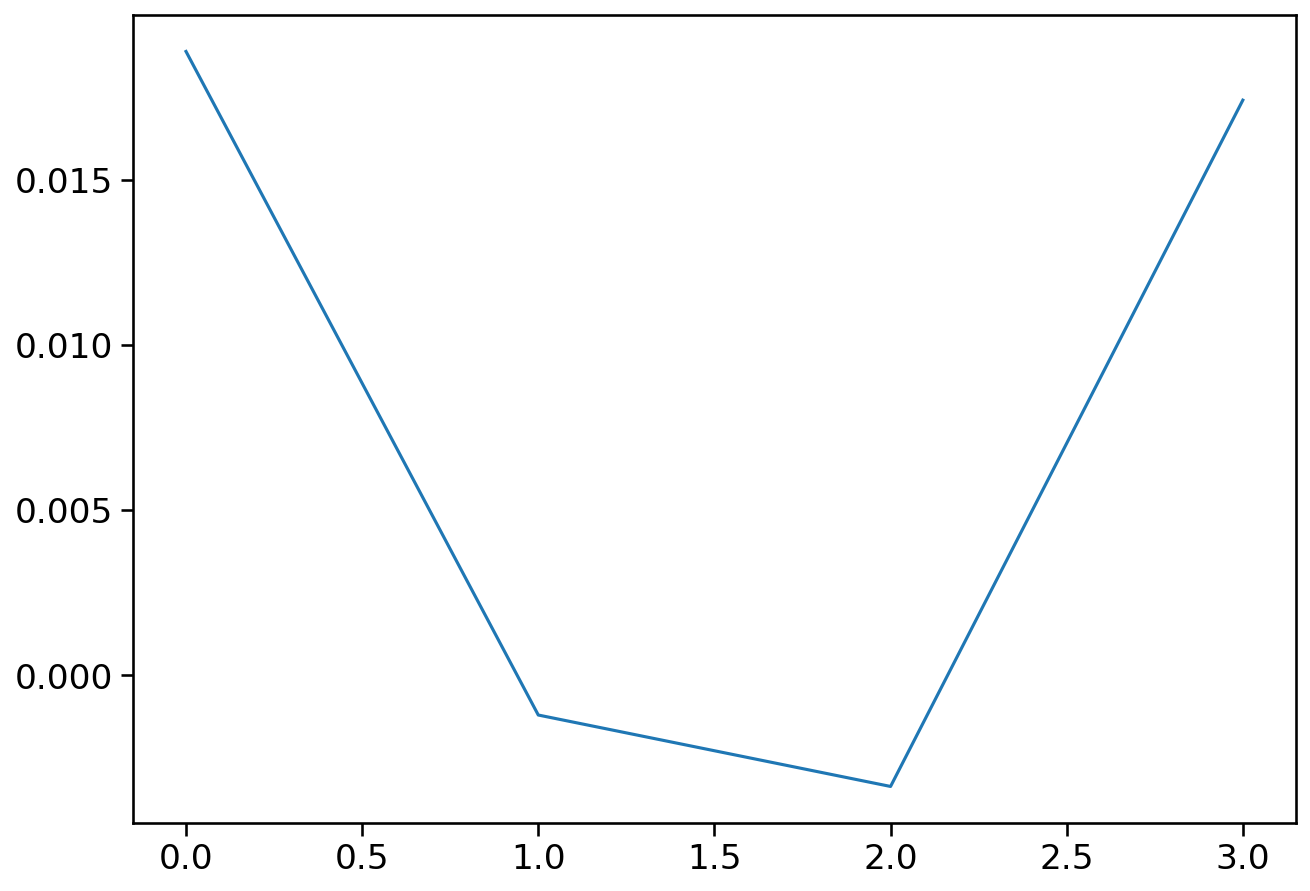

In [167]:
print(sub_end_frame-sub_start_frame)
plt.plot(dff_avg[sub_start_frame:sub_end_frame])

In [168]:
default_color = (0.5, 0.5, 0.5)  # Use gray as a default color, adjust as needed

In [169]:
def plot_images_with_time(start_time, stop_time, dataset, trial):
    '''
    Plot images with time.

    Parameters:
    - start_time: Start time of the trial.
    - stop_time: Stop time of the trial.
    - dataset: Dataset containing stimulus presentations.
    - trial: Trial information.

    Returns:
    - fig: Figure object.
    - axs: AxesSubplot objects.
    '''
    # Filter stimulus presentations based on start and stop times
    filtered_stimuli = dataset.stimulus_presentations[
        (dataset.stimulus_presentations['start_time'] >= start_time) &
        (dataset.stimulus_presentations['start_time'] <= stop_time)
    ]

    # Extract image names using a list comprehension
    images = [image_name for image_name in filtered_stimuli['image_name']]

    # Visualize images
    fig, axs = plt.subplots(1, len(images), squeeze=False)
    axs = axs.flatten()

    for i, ax in enumerate(axs):
        image_name = images[i]
        # Check if the image_name is 'omitted', if so, display a blank image
        if image_name == 'omitted':
            # Create a blank image (assuming the size is 63x100 pixels and gray)
            blank_image = np.ones((63, 100), dtype=np.uint8) * 255  # Create a white image
            ax.imshow(blank_image, cmap='gray')
            ax.set_title('Omitted')
        else:
            # Display the actual image
            ax.imshow(dataset.stimulus_templates['warped'].get(image_name, default_color), cmap='gray')
            ax.set_title(image_name)

        ax.axis('off')

    fig.set_size_inches(20, 20)

    return fig, axs

In [170]:
def plot_stimuli(dataset, trial, ax):
    '''
    Plot stimuli as colored bars on specified axis.
    
    Parameters:
    - dataset: Dataset containing stimulus information.
    - trial: Trial for which stimuli are plotted.
    - ax: Axis object to plot stimuli on.
    '''
    # Extract start_time and stop_time from the trial
    start_time = float(trial['start_time_x'])
    stop_time = float(trial['stop_time_x'])

    # Create a boolean mask for rows within the specified time range
    mask = (dataset.stimulus_presentations['end_time'] >= start_time) & \
           (dataset.stimulus_presentations['start_time'] <= stop_time) & \
           (~dataset.stimulus_presentations['omitted'])

    # Use the boolean mask to filter the DataFrame
    stimuli = dataset.stimulus_presentations[mask]
    
    # Plot colored bars for each stimulus presentation
    for idx, stimulus in stimuli.iterrows():
        ax.axvspan(stimulus['start_time'], stimulus['end_time'], color='red', alpha=0.5)
        
    return stimuli

def plot_dff(dataset, trial, ax, cell_avg=False):
    '''
    Plot each cell's dff response for a given trial.
    
    Parameters:
    - dataset: Dataset containing dF/F traces.
    - trial: Trial for which dF/F responses are plotted.
    - ax: Axis object to plot dF/F responses on.
    - cell_avg: Whether to plot average dF/F across cells (default is False).
    '''
    # Extract dF/F traces from the dataset
    dff_array = np.vstack(dataset.dff_traces['dff'].values)
    
    # Create a boolean mask for timestamps within the trial's time range
    trial_mask = (dataset.ophys_timestamps >= trial['start_time_x']) & \
                 (dataset.ophys_timestamps <= trial['stop_time_x'])
    
    # Filter dF/F traces based on the trial mask
    dff_trial = dff_array[:, trial_mask]
    
    # Plot dF/F responses
    if cell_avg:
        ax.plot(dataset.ophys_timestamps[trial_mask], np.mean(dff_trial, 0))
    else:
        ax.plot(dataset.ophys_timestamps[trial_mask], dff_trial.T)
        ax.set_title('deltaF/F responses')
        ax.set_ylabel('dF/F')
    
    return np.mean(dff_trial, 0), trial_mask

def make_trial_plot(dataset, trial, cell_avg=False):
    '''
    Combine all plots for a given trial.
    
    Parameters:
    - dataset: Dataset to plot.
    - trial: Trial for the dataset.
    - cell_avg: Whether to plot average dF/F across cells (default is False).
    '''
    # Create a time array from start_time to stop_time
    start_time = float(trial['start_time_x'])
    stop_time = float(trial['stop_time_x'])
    time_array = np.linspace(start_time, stop_time, num=1000)  # You can adjust the number of points (num) as needed

    # Create a figure and axis object for plotting
    fig, ax = plt.subplots(figsize=(15, 4))  # Adjust the height as needed

    # Plot stimuli
    stim = plot_stimuli(dataset, trial, ax)

    # Plot dF/F
    dff, trial_mask = plot_dff(dataset, trial, ax, cell_avg=cell_avg)

    # Set x-axis limits and labels
    ax.set_xlim(start_time, stop_time)
    ax.set_xlabel('time in session (seconds)')
    ax.set_ylabel('dF/F')

    # Adjust layout to prevent overlap
    fig.tight_layout()

    plt.show()
    return stim, dff, trial_mask

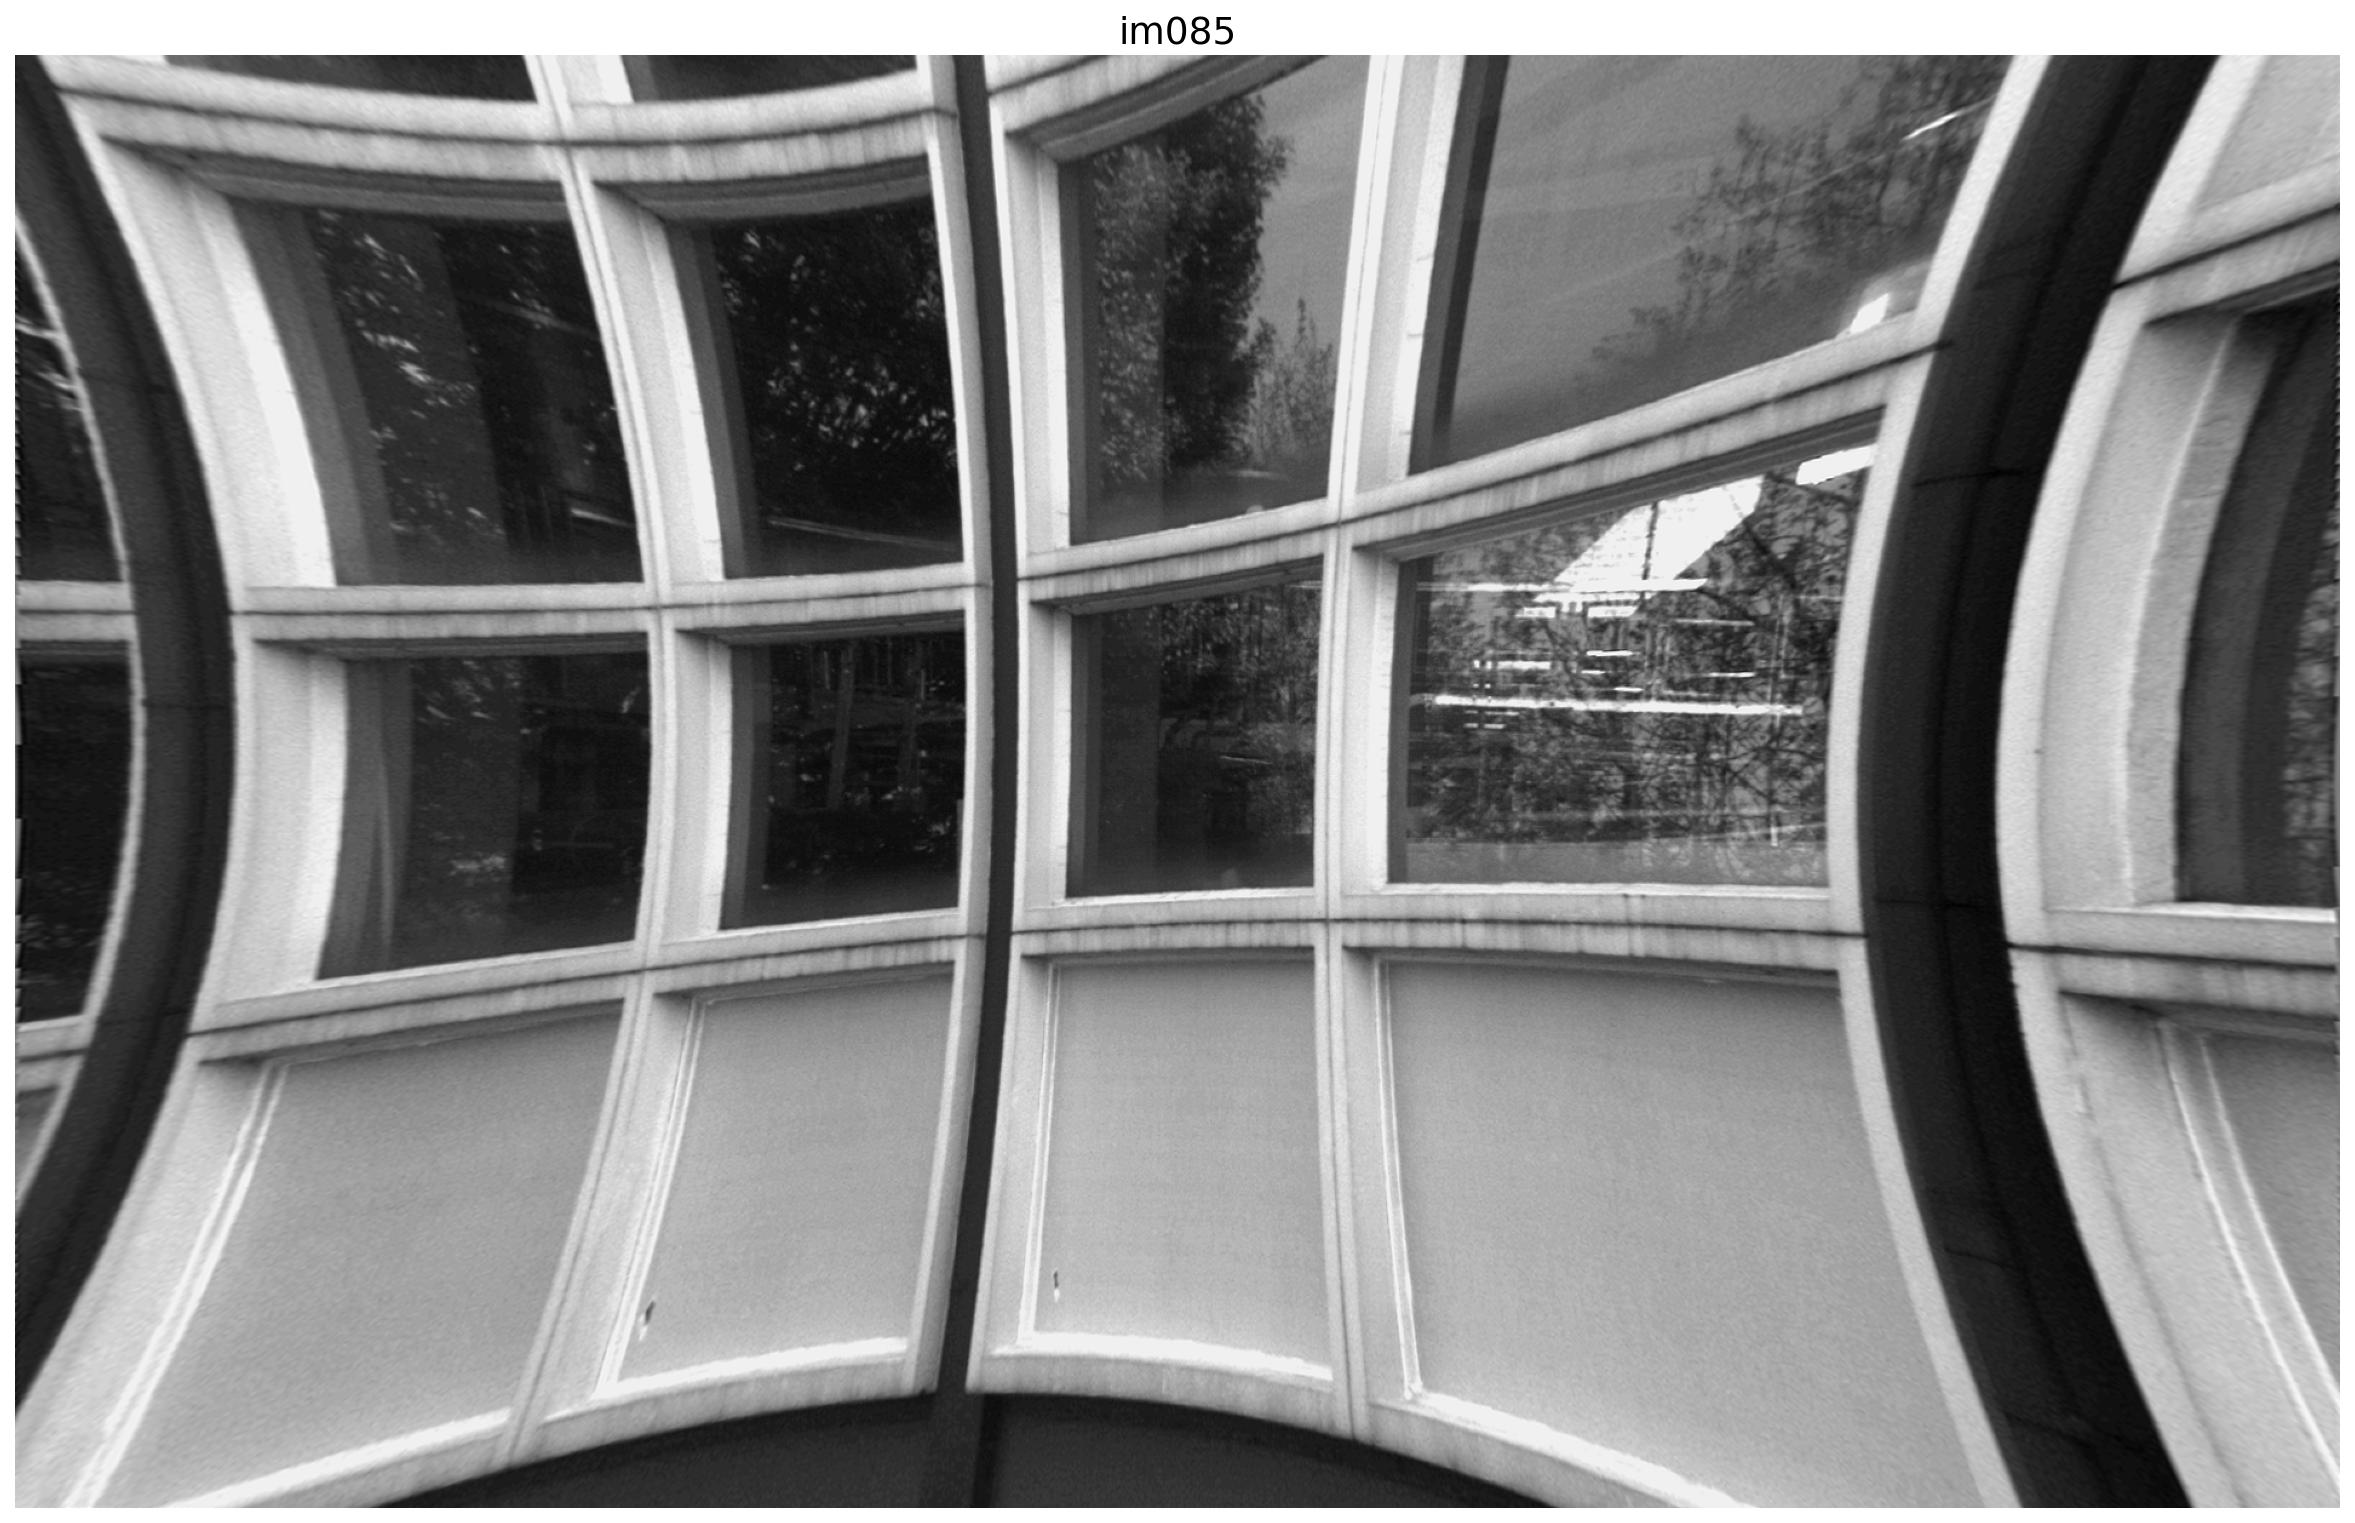

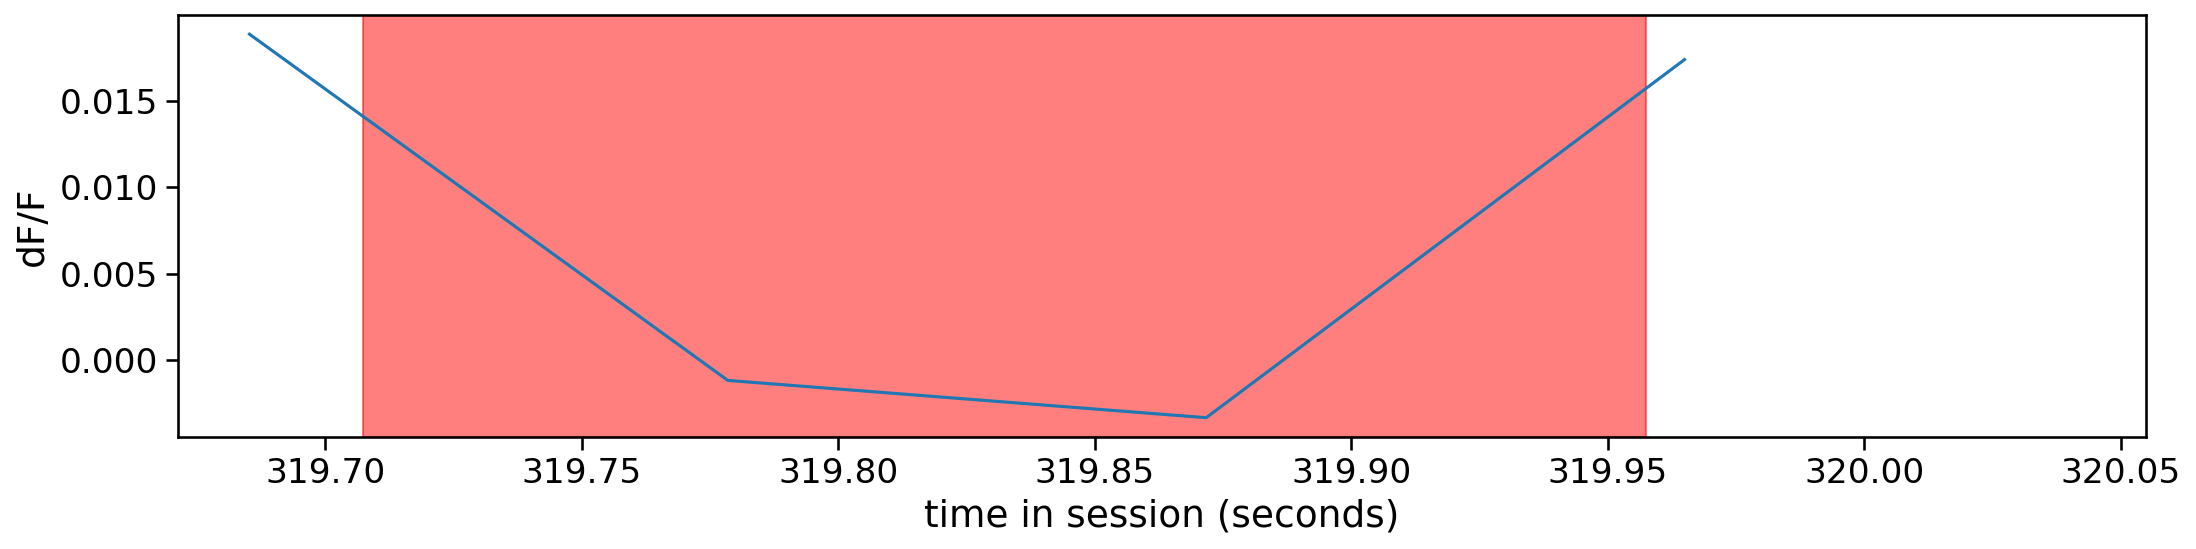

In [171]:
# plot trial
# Show the stimulus images with names
fig, axs = plot_images_with_time(start_time, stop_time, dataset, trial)
plt.show()

# Plot the dF/F trace with time of stimulus presentation shown
stim, dff, trial_mask = make_trial_plot(dataset, trial, cell_avg=True)

In [172]:
start_time

319.67122

In [173]:
stop_time

320.05488